In [50]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Categorical, Normal, StudentT, Dirichlet, InverseGamma, ParamMixture, MultivariateNormalDiag

import pandas as pd
import seaborn as sns
%matplotlib inline

%load_ext autoreload

import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector
ds = tf.contrib.distributions


try:
    from tensorflow.contrib.distributions import FULLY_REPARAMETERIZED
except Exception as e:
    raise ImportError("{0}. Your TensorFlow version is not supported.".format(e))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def mixtureOfGaussians(N = 100, D=2, K=2):
    """
    Explicit latent variables for the mixture assignments (as opposed to the collapsed version with assigments marginalized)
    """
    pi = Dirichlet(tf.ones(K))
    mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
    sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
    x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                     MultivariateNormalDiag,
                     sample_shape=N)
    z = x.cat
    return (pi,mu,sigmasq,z,x)

In [125]:
K = 3
D = 1
pi = Dirichlet(tf.ones(K))
z = Categorical(probs=pi)
sigmasq = InverseGamma(tf.ones([D]), tf.ones([D]), sample_shape=K)
x = ds.MixtureSameFamily(mixture_distribution=z,components_distribution=Normal(loc=tf.zeros([3]),scale=tf.sqrt(sigmasq)))

In [129]:
z.sample().eval()

0

In [127]:
x.sample()

<tf.Tensor 'MixtureSameFamily_37/sample/Reshape:0' shape=(3,) dtype=float32>

In [140]:
K = 3
D = 2
pi = Dirichlet(tf.ones([D,K]))
z = Categorical(probs=pi)
sigmasq = InverseGamma(tf.ones([D,K]), tf.ones([D,K]))
x = ds.MixtureSameFamily(mixture_distribution=z,components_distribution=Normal(loc=tf.zeros([D,K]),scale=tf.sqrt(sigmasq)))

In [134]:
z.sample().eval()

array([0, 1], dtype=int32)

In [135]:
Normal(loc=tf.zeros([D,K]),scale=tf.sqrt(sigmasq))

<ed.RandomVariable 'Normal_27/' shape=(2, 3) dtype=float32>

In [141]:
x.sample()

ValueError: Shapes (2, 2) and (2,) are not compatible

In [108]:
mog_sample = x.sample([1000]).eval()
plt.hist(mog_sample.flatten(),'auto')

ValueError: Shapes (1000, 1000, 1) and (?, 1) are not compatible

In [88]:
mog_sample.flatten().shape

(3000,)

In [ ]:
class newNormal(Distribution):
	def __init__(self,params,validate_args=False,allow_nan_stats=True,name="newNormal"):
		parameters = locals()
		with tf.name_scope(name, values=[params]):
			with tf.control_dependencies([]):
				self._params = tf.identity(params, name="params")
				try:
					self._n = tf.shape(self._params)[0]
				except ValueError:  # scalar params
					self._n = tf.constant(1)
		
		super(newNormal, self).__init__(
			dtype=self._params.dtype,
			reparameterization_type=FULLY_REPARAMETERIZED,
			validate_args=validate_args,
			allow_nan_stats=allow_nan_stats,
			parameters=parameters,
			graph_parents=[self._params, self._n],
			name=name)

	@staticmethod
	def _param_shapes(sample_shape):
		return {"params": tf.convert_to_tensor(sample_shape, dtype=tf.int32)}

	@property
	def params(self):
		"""Distribution parameter."""
		return self._params

	@property
	def n(self):
		"""Number of samples."""
		return self._n
	
	def _log_prob(self, value):
		raise NotImplementedError("log_prob is not implemented")

	def _sample_n(self, n, seed=None):
		input_tensor = self.params
		r = Uniform(low=input_tensor[0],high=input_tensor[1])._sample_n(n, seed)
		b = Uniform(low=0.0,high=6.283185)._sample_n(n, seed)
		x = tf.sqrt(r)*tf.cos(b)
		y = tf.sqrt(r)*tf.sin(b)
		z = Normal(loc=input_tensor[2],scale=input_tensor[3])._sample_n(n, seed)
		return tf.stack([x, y, z], axis=1)

In [100]:
from edward.models import RandomVariable
from tensorflow.contrib.distributions import Distribution

class MixtureOfUnivariateNormal(RandomVariable, Distribution):
    def __init__(self, params,validate_args=False,allow_nan_stats=True,name="MixtureOfUnivariateNormal"):
        parameters = locals()
        with tf.name_scope(name, values=[params]):
            with tf.control_dependencies([]):
                self._params = tf.identity(params, name="params")
            try:
                self._n = tf.shape(self._params)[0]
            except ValueError:  # scalar params
                self._n = tf.constant(1)
        super(MixtureOfUnivariateNormal, self).__init__(
            dtype=self._params.dtype,
            reparameterization_type=FULLY_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            graph_parents=[self._params, self._n],
            name=name)
    
    @property
    def params(self):
        """Distribution parameter."""
        return self._params

    def _log_prob(self, value):
        raise NotImplementedError("log_prob is not implemented")  

    def _sample_n(self, n, seed=None):
        input_tensor = self.params # K,D
        K = input_tensor[0]
        D = input_tensor[1] # D here means number of independent MoGs, not dimensionality of the MoG
        pi = Dirichlet(tf.ones([D,K]))
        z = Categorical(probs=pi)
        sigmasq = InverseGamma(tf.ones([D,K]), tf.ones([D,K]))
        x = ds.MixtureSameFamily(mixture_distribution=z,components_distribution=Normal(loc=tf.zeros([D,K]),scale=tf.sqrt(sigmasq)))
        return x.sample()

In [103]:
mog = MixtureOfUnivariateNormal([3,2])

3
2


In [105]:
mog.sample().eval()

3
2


InvalidArgumentError: Input to reshape is a tensor with 2 values, but the requested shape has 1
	 [[Node: MixtureOfUnivariateNormal_35/sample_2/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](MixtureOfUnivariateNormal_35/sample_2/MixtureSameFamily_1/sample/Reshape, MixtureOfUnivariateNormal_35/sample_2/concat)]]

Caused by op u'MixtureOfUnivariateNormal_35/sample_2/Reshape', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-105-30b6c63d40e9>", line 1, in <module>
    mog.sample().eval()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/distributions/distribution.py", line 665, in sample
    return self._call_sample_n(sample_shape, seed, name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/distributions/distribution.py", line 647, in _call_sample_n
    samples = array_ops.reshape(samples, final_shape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 3938, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 2 values, but the requested shape has 1
	 [[Node: MixtureOfUnivariateNormal_35/sample_2/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](MixtureOfUnivariateNormal_35/sample_2/MixtureSameFamily_1/sample/Reshape, MixtureOfUnivariateNormal_35/sample_2/concat)]]


In [15]:
mog1 = mixtureOfGaussians(N=100,D=2,K=3)

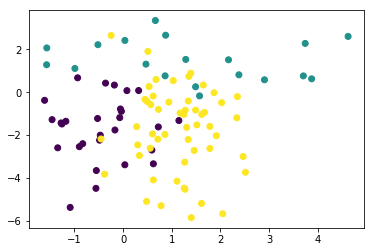

In [6]:
sess = ed.get_session()
mog1_sample = sess.run([v.value() for v in mog1]) # ancestral sampling

pi_true,mu_true,sigmasq_true,z_true,x_true = mog1_sample
# plot means
# plt.scatter(*mu_true.T,s=300)
# plot observation color coded by assignments
plt.scatter(*x_true.T, c=z_true)

In [9]:
def independentFactorAnalyzer(M=100,D=2,K=1,tau=1.,lamda=20.):
    lamda = lamda*tf.ones([K])
    sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))
    w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(np.abs(tau)*np.abs(lamda),[D]),[D,K]))
    pi_source,mu_source,sigmasq_source,z_assignments_source,x_source = mixtureOfGaussians(N=M,D=1,K=K)
    z = x_source
    mu = Normal(tf.zeros([D]),tf.ones([D]))
    x = MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z, transpose_b=True)),mu), tf.reshape(tf.tile(sigma,[M]),[M,D]))
    return (pi_source,mu_source,sigmasq_source,z_assignments_source,w,z,mu,sigma,x)

In [10]:
ifa1 = independentFactorAnalyzer(M=1000,D=2,K=3)

In [ ]:
sess = ed.get_session()
ifa1_sample = sess.run([v.value() for v in ifa1]) # ancestral sampling

pi_source,mu_source,sigmasq_source,z_assignments_source,w,z,mu,sigma,x = mog1_sample